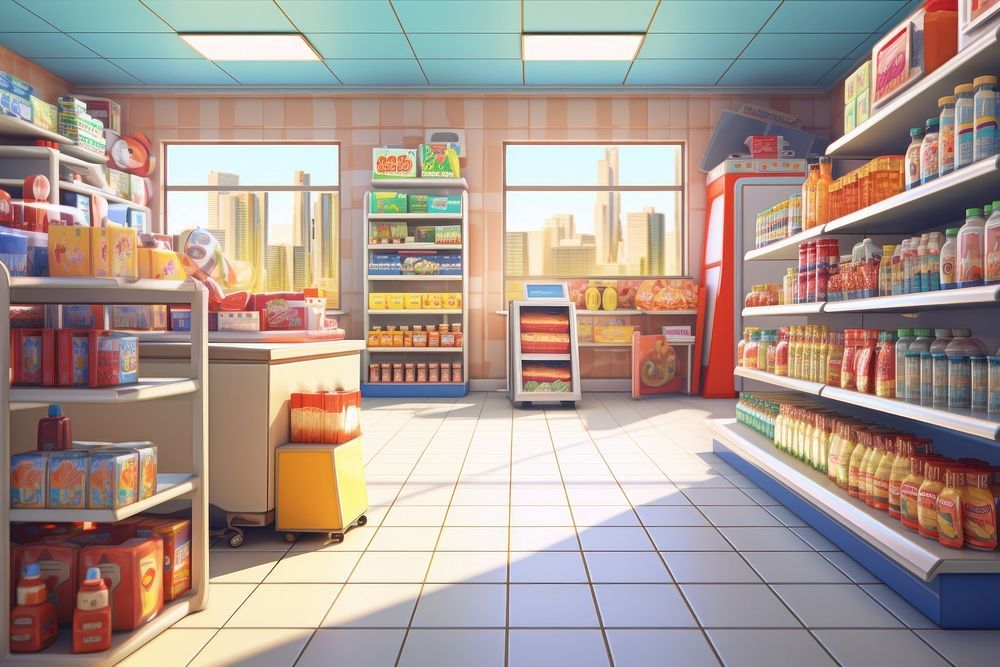

**Big Mart Sales Dataset - Description**

The dataset is commonly used for regression and retail analytics tasks. It contains historical sales data of products across multiple outlets of Big Mart, a retail chain. The goal is to **predict the sales of products** based on various features.

In [16]:
from zipfile import ZipFile as zp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [2]:
dz = zp("/content/dataset.zip")

data_train = pd.read_csv(dz.open("Train-Set.csv"))
data_train_copy = data_train.copy()

data_test = pd.read_csv(dz.open("Test-Set.csv"))
data_test_copy = data_test.copy()

In [3]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ProductID          8523 non-null   object 
 1   Weight             7060 non-null   float64
 2   FatContent         8523 non-null   object 
 3   ProductVisibility  8523 non-null   float64
 4   ProductType        8523 non-null   object 
 5   MRP                8523 non-null   float64
 6   OutletID           8523 non-null   object 
 7   EstablishmentYear  8523 non-null   int64  
 8   OutletSize         6113 non-null   object 
 9   LocationType       8523 non-null   object 
 10  OutletType         8523 non-null   object 
 11  OutletSales        8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [4]:
print(f"Train Set Shape: {data_train.shape}")
print(f"Test Set Shape: {data_test.shape}")

Train Set Shape: (8523, 12)
Test Set Shape: (5681, 11)


Using "*.shape* " we can learn size of our  dataset (number of columns and rows)

In [5]:
# Replace values

data_train['FatContent'] = data_train['FatContent'].replace({'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg': 'Regular'})
data_test['FatContent'] = data_test['FatContent'].replace({'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg': 'Regular'})

In [6]:
data_train.isnull().sum()

,0
ProductID,0
Weight,1463
FatContent,0
ProductVisibility,0
ProductType,0
MRP,0
OutletID,0
EstablishmentYear,0
OutletSize,2410
LocationType,0


In [7]:
data_test.isnull().sum()

,0
ProductID,0
Weight,976
FatContent,0
ProductVisibility,0
ProductType,0
MRP,0
OutletID,0
EstablishmentYear,0
OutletSize,1606
LocationType,0


Alternatively, we can use "*.isna().sum()* ", there is no difference between them.

**OOOPS!** *WE GOT A PROBLEM...*

I mean, in train data "Weight" column contains 1463 NULL values (17.2%). In the same way, "OutletSize" column contains 2410 NULL values (28.3%).

<Axes: >

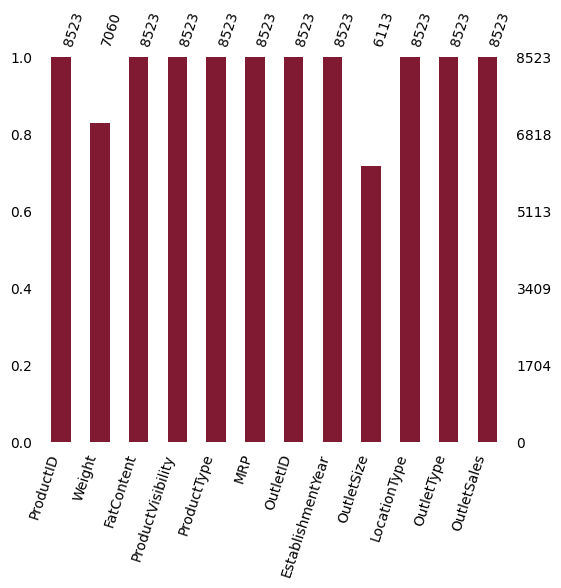

In [8]:
ms.bar(data_train, figsize = (6,5), fontsize = 10, label_rotation = 72, color = (0.5, 0.1, 0.2))

<Axes: >

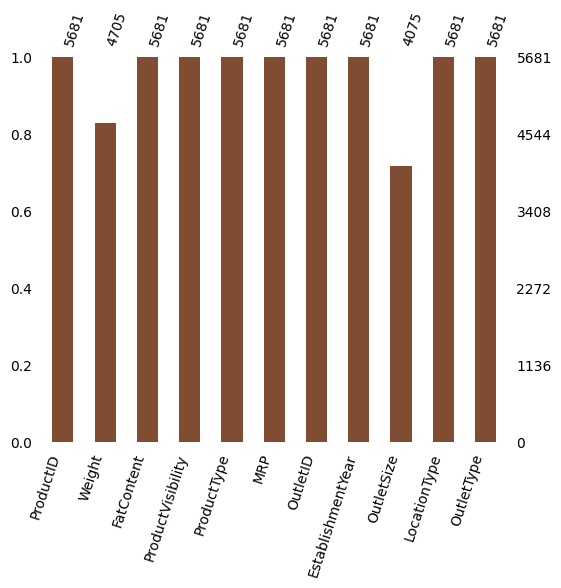

In [9]:
ms.bar(data_test, figsize = (6,5), fontsize = 10, label_rotation = 72, color = (0.5, 0.3, 0.2))

After visualization we can see the problem clearly. Thus, let's fix it using *fillna()*


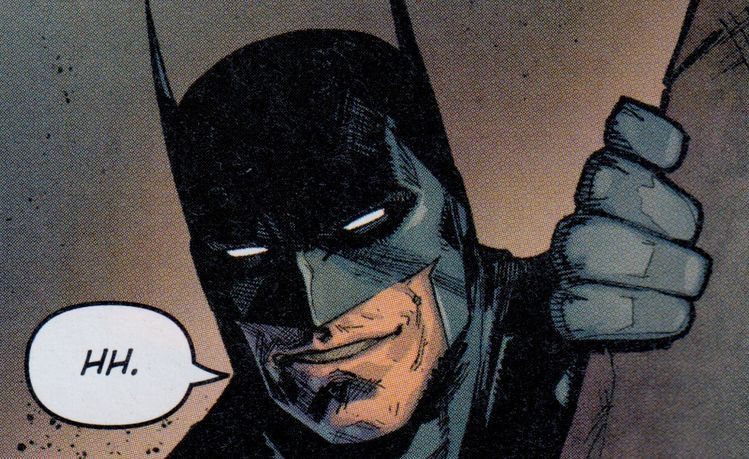

In [10]:
data_train['Weight'] = data_train['Weight'].fillna(data_train['Weight'].mean())
data_test['Weight'] = data_test['Weight'].fillna(data_test['Weight'].mean())

data_train['OutletSize'] = data_train['OutletSize'].fillna(data_train['OutletSize'].mode()[0])
data_test['OutletSize'] = data_test['OutletSize'].fillna(data_test['OutletSize'].mode()[0])

print(f"Train:\n{data_train.isna().sum()}")
print("---------")
print(f"Test:\n{data_test.isna().sum()}")

Train:
ProductID            0
Weight               0
FatContent           0
ProductVisibility    0
ProductType          0
MRP                  0
OutletID             0
EstablishmentYear    0
OutletSize           0
LocationType         0
OutletType           0
OutletSales          0
dtype: int64
---------
Test:
ProductID            0
Weight               0
FatContent           0
ProductVisibility    0
ProductType          0
MRP                  0
OutletID             0
EstablishmentYear    0
OutletSize           0
LocationType         0
OutletType           0
dtype: int64


In [17]:
data_train.loc[data_train['ProductVisibility'] == 0, 'ProductVisibility'] = data_train['ProductVisibility'].mean()
data_test.loc[data_test['ProductVisibility'] == 0, 'ProductVisibility'] = data_test['ProductVisibility'].mean()

a product cannot have 0 visibility if it's being sold. For that reason, these zeroes are likely incorrect data entries or missing values.

In [11]:
data_train['OutletAge'] = 2025 - data_train['EstablishmentYear']
data_test['OutletAge'] = 2025 - data_test['EstablishmentYear']

It creates a new feature called "OutletAge" by subtracting each store's EstablishmentYear from the current year, assumed to be 2025. This gives the number of years each store has been operating, which can help the model understand if store age influences sales performance.

In [12]:
data_train.loc[data_train['ProductType'].str.contains('Non-Consumable'), 'FatContent'] = 'Non-Edible'
data_test.loc[data_test['ProductType'].str.contains('Non-Consumable'), 'FatContent'] = 'Non-Edible'

It updates the FatContent column for all products labeled as 'Non-Consumable' in the ProductType column by setting their fat content to 'Non-Edible'. This is a data cleaning and consistency step to ensure that non-edible products, which logically shouldn't have a fat content, are properly marked and not misrepresented in the dataset. It helps avoid misleading the model with irrelevant or incorrect fat values.

In [13]:
# Encoding

le = LabelEncoder()
for column in ['OutletID', 'OutletSize', 'LocationType', 'OutletType']:
    data_train[column] = le.fit_transform(data_train[column])
    data_test[column] = le.transform(data_test[column])

data_train = pd.get_dummies(data_train, columns = ['FatContent', 'ProductType'], drop_first = True)
data_test = pd.get_dummies(data_test, columns = ['FatContent', 'ProductType'], drop_first = True)

1. **LabelEncoder**

It is used to convert categorical labels into numeric values. It's mostly used for target variables or ordinal features where the order matters. However, it's not ideal for nominal features, as the model might misinterpret the numerical order.

2. **pd.get_dummies**

pd.get_dummies performs one-hot encoding, converting each category in a column into separate binary columns. It’s suitable for nominal features because it avoids implying any order between categories. This method helps machine learning models treat each category as independent.

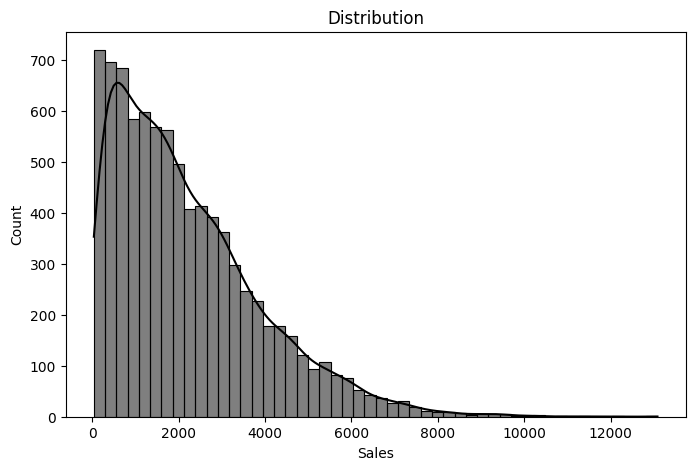

In [14]:
plt.figure(figsize = (8,5))
sns.histplot(data_train['OutletSales'], bins = 50, kde = True, color = 'k')
plt.title("Distribution")
plt.xlabel("Sales")
plt.show()

The plot shows the *distribution of the Sales variable* using a histogram with a KDE (Kernel Density Estimate) overlay.

1. The distribution is **right-skewed**, meaning most of the sales values are concentrated on the lower end, while fewer outlets have very high sales.
2. This kind of skewed distribution is common in sales data where a few products or stores dominate total sales.

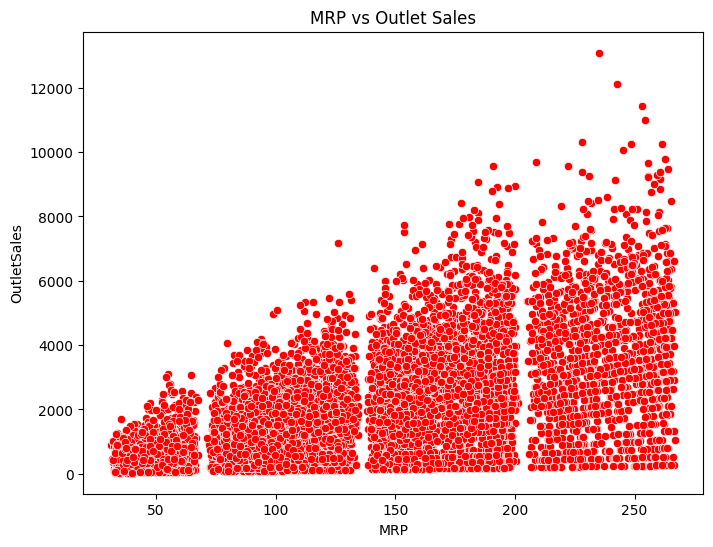

In [15]:
plt.figure(figsize = (8, 6))
sns.scatterplot(x = 'MRP', y = 'OutletSales', data = data_train, color = 'r')
plt.title('MRP vs Outlet Sales')
plt.show()

This is a **scatter plot** showing the relationship between *MRP (Maximum Retail Price)* and *Outlet Sales*.

1. There is a **positive correlation** between MRP and Outlet Sales. The MRP increases, the sales also tend to rise.
* The points are grouped in **distinct vertical bands**, indicating that MRP values might be clustered in specific price ranges.

In [18]:
# features and target

x = data_train.drop(['OutletSales', 'ProductID'], axis = 1)
y = data_train['OutletSales']

# splitting data into train and test sets

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

# scaling

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

* *Scaling*

Scaling in ML is all about getting your data to play nice together so your model doesn't trip over numbers that are on totally different scales like height in CMs say 180 and weight in KGs say 80 without scaling big numbers can bully smaller ones in algorithms like KNN, SVM or neural networks because they rely on distances or gradients scaling makes sure every feature gets an equal shot so your model learns better and faster its super important for stuff like gradient descent where big differences in scale can slow things down or mess up results plus it keeps things fair so no feature dominates just cause its numbers are bigger you dont always need scaling though like with decision trees or random forests since they don't care about scale but for most other models its a must.

Now, let's talk two big scaling methods **MinMaxScaler and Z-score** standardization a.k.a StandardScaler;

** *MinMaxScaler* ** takes your data and squashes it into a set range usually 0 to 1 it works by taking each value subtracting the smallest value in the feature and dividing by the range which is max minus min the formula is x scaled equals $X_{\text{scaled}} = \frac{X - X_{\min}}{X_{\max} - X_{\min}}$* so if the heights are 170, 180, 190 the "min is 170",  "max is 190",  "range is 20". Thus,

* 180 => 180 minus 170 divided by 20 which is *0.5*
* 170 => 170 minus 170 divided by 20 which is *0.0*
* 190 => 190 minus 170 divided by 20 which is *1.0*

Eventually, this puts everything between 0 and 1 keeping the relative distances between values its great for models that like bounded data like NNs but watch out for outliers cause a crazy high or low value can squish everything else.

On the other hand, * **Z-score standardization or StandardScaler** * is different it makes your data have a mean of 0 and a standard deviation of 1 basically centering it around zero with a consistent spread the formula is, ($X_{\text{scaled}} = \frac{X - \mu}{\sigma}$). This method assumes your data is kinda normal bell curve ish and works awesome for algorithms like linear regression or SVM but outliers can mess with the mean and standard deviation so if your data’s wild you might need something else like RobustScaler.

* Mean: $\mu = \frac{180 + 170 + 190}{3} = 180$
* Std: $\sigma = \sqrt{\frac{(180-180)^2 + (170-180)^2 + (190-180)^2}{3}} = \sqrt{\frac{0 + 100 + 100}{3}} \approx 8$

Then;
* Z(180) => 180 minus 180 divided by 8 which is *0.0*
* Z(170) => 170 minus 180 divided by 8 which is *-1.2*
* Z(190) => 190 minus 180 divided by 8 which is *1.2*

Key points always scale after splitting your data into training and test sets to avoid data leakage where test info sneaks into training only fit your scaler on training data then use it to transform both training and test data MinMax is good for bounded ranges Z-score is better for normally distributed data if you got outliers RobustScaler might be your friend since it uses medians instead of means you can also reverse scaling to get back to original values which is handy for interpreting results.


In [19]:
# building a RF model

model_rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
model_rf.fit(x_train, y_train)
pred_rf = model_rf.predict(x_test)

# evaluate the RF model

rmse = root_mean_squared_error(y_test, pred_rf)
r2 = r2_score(y_test, pred_rf)

print(f"RF RMSE: {rmse}")
print(f"RF R2 Score: {r2:.2f}")

RF RMSE: 1083.5458072553229
RF R2 Score: 0.57


***RandomForestRegressor***

It is an **ensemble** of decision trees, and each tree learns from a random subset of data and features (this is called *bagging*). When predicting, it averages the outputs from all trees.

**1) Root Mean Squared Error (RMSE)**

It is the *square root of the average of the squared differences* between the actual and predicted values.

*formula:* $\text{rmse} = \sqrt{\frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2}$

In here,

* $y_i$: Actual value
* $\hat{y}_i$: Predicted value
* $n$: Number of observations

For instance, if RMSE = 4.5 in a sales prediction task, it means the model’s predictions are off by 4.5 units on average.

**2) R² Score (Coefficient of Determination)**

It measures the *proportion of variance in the target variable* that is explained by the model.

*formula:* $r^2 = 1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2}$

In here,

* $\bar{y}$: Mean of actual values
* The numerator is the residual sum of squares
* The denominator is the total sum of squares

For example, if R² = 0.87, the model explains 87% of the variability in the target variable.

*Note:*

* R² = 1: Perfect predictions.
* R² = 0: Model does no better than the mean.
* R² < 0: Model is worse than just predicting the mean.

In [20]:
# building a XGB model

model_xgb = xgb.XGBRegressor(n_estimators = 100, learning_rate = 0.1, max_depth = 2, random_state = 0)
model_xgb.fit(x_train, y_train)
pred_xgb = model_xgb.predict(x_test)

# evaluate the RF model

rmse_xgb = root_mean_squared_error(y_test, pred_xgb)
r2_xgb = r2_score(y_test, pred_xgb)

print(f"XGB RMSE: {rmse_xgb}")
print(f"XGB R2 Score: {r2_xgb:.2f}")

XGB RMSE: 1021.7146068005285
XGB R2 Score: 0.62


***XGBRegressor (Extreme Gradient Boosting)***

Based on *Gradient Boosting* technique, it learns *sequentially*, improving the next tree based on the errors of the previous ones. In addition, it optimizes performance using *gradient descent*. Furthermore, it supports *regularization*.

**1) Root Mean Squared Error (RMSE)**

It is the *square root of the average of the squared differences* between the actual and predicted values.

*formula:* $\text{rmse} = \sqrt{\frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2}$

In here,

* $y_i$: Actual value
* $\hat{y}_i$: Predicted value
* $n$: Number of observations

For instance, if RMSE = 4.5 in a sales prediction task, it means the model’s predictions are off by 4.5 units on average.

**2) R² Score (Coefficient of Determination)**

It measures the *proportion of variance in the target variable* that is explained by the model.

*formula:* $r^2 = 1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2}$

In here,

* $\bar{y}$: Mean of actual values
* The numerator is the residual sum of squares
* The denominator is the total sum of squares

For example, if R² = 0.87, the model explains 87% of the variability in the target variable.

*Note:*

* R² = 1: Perfect predictions.
* R² = 0: Model does no better than the mean.
* R² < 0: Model is worse than just predicting the mean.

In [ ]:
# Finally

As a result, our XGB model (62%) works better than RandomForest model (57%).

***I WOULD LIKE TO EXPRESS MY SINCERE GRATITUDE FOR YOUR TIME AND CONSIDERATION***

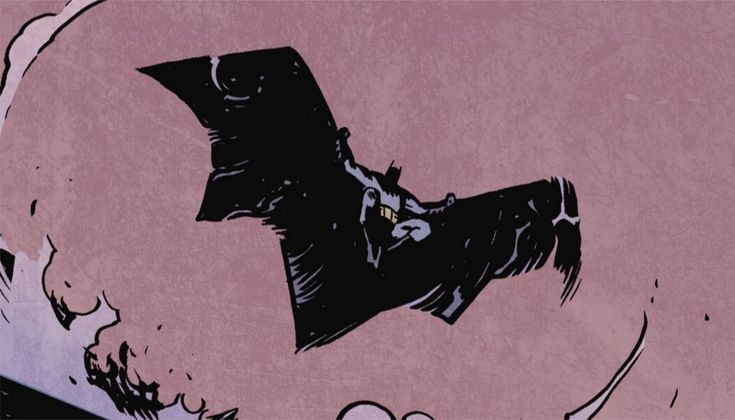